In [2]:
## Import the necessary libraries

import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import uniform
import sklearn.mixture as mixture_model
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as normal

from scipy.optimize import approx_fprime
import scipy.optimize as op

In [4]:
## Define the boundary of the rare event set

'''
The rare event set boundary is set by the function f() and in this case, 
the boundary is a circle of radius 2.5 with center at (10,10)
'''

def f(x, mu_non_eps, thres):
    eps = np.linalg.norm(x-mu_non_eps, axis=1)**2 > thres
    
    return eps

mu_non_eps=[10, 10]
thres = 2.5**2

# The parameters of the sampling distribution are : 
mu_0 = [10, 10]
sigma_0 = 0.25*np.eye(2)

# The sampling distribution p is considered to be Gaussian
p = normal(mu_0, sigma_0);

In [7]:
## Define the mesh of the state space to plot the contours of the rare event boundary

lb=7.5
ub=12.5

x1_grid = np.linspace(5, 15, 100)
x2_grid = np.linspace(5, 15, 100)

x1s, x2s = np.meshgrid(x1_grid, x2_grid)

xs = np.array([x1s.reshape(-1), x2s.reshape(-1)]).transpose()
ys = (f(xs, mu_non_eps, thres)).reshape(x1s.shape)

ps = p.pdf(xs).reshape(x1s.shape)

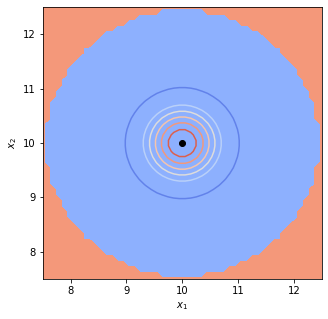

In [8]:
## Plot the rare event set 

plt.figure(figsize=(5, 5))
plt.contourf(x1s, x2s, ys, levels=[-1, 0, 1], cmap="coolwarm")
plt.rcParams["font.size"] = 18
plt.scatter(mu_0[0], mu_0[1], c="k", label="$\mu_0$")
plt.contour(x1s, x2s, ps, cmap="coolwarm")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(lb, ub)
plt.ylim(lb, ub)
plt.show()

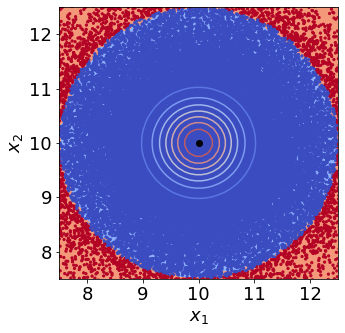

In [9]:
## Sampling from the normal distribution p for training classifier

N=50000 # number of samples
X=normal(mu_0, 6*sigma_0).rvs(N)
Y=f(X, mu_non_eps, thres)

# Plot the sampled points
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 18
plt.contourf(x1s, x2s, ys, levels=[-1, 0, 1], cmap="coolwarm")
plt.contour(x1s, x2s, ps, cmap="coolwarm", alpha=0.8)

plt.scatter(X[:,0], X[:,1], s=5, c=Y, cmap="coolwarm", label="Sample from p")
plt.scatter(mu_0[0], mu_0[1], c="k", label="$\mu_0$")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(lb, ub)
plt.ylim(lb, ub)

plt.show()

In [11]:
# Define the neural network classifier model (single layer NN)

import torch
import foolbox
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Feed-forward architecture with ReLU
class model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        
        return out

In [13]:
## Function to train the neural network using the sampled data points

def trainer(train_input, train_label, batch_size = 1000, n_iters = 1000, 
            log=False, it_interval=100, input_dim=2, hidden_dim=5, output_dim=2):
    
    train_dataset = []
    for i in range(train_label.shape[0]): 
        train_dataset.append([train_input[i,:], train_label[i]])

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

    input_dim = input_dim
    hidden_dim = hidden_dim
    output_dim = output_dim
    
    num_epochs = n_iters / (len(train_dataset) / batch_size)
    num_epochs = int(num_epochs)

    net = model(input_dim, hidden_dim, output_dim).to(device)
    optimizer = optim.Adam(net.parameters(), lr=5e-03)
    
    #weights
    class_weight = torch.Tensor([0.1, 5]).to(device)
    sample_weight = torch.ones(batch_size).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weight, reduction='none')


    it = 1
    if log == True: print("Logging set as true:")
        
    for epoch in range(num_epochs):
        for i, (data, target) in enumerate(train_loader):
            it = it + 1
            X = Variable(torch.Tensor(data.float())).to(device)
            y = Variable(torch.Tensor(target.float())).to(device)      
            optimizer.zero_grad()        
            net_out = net(X)
            loss = criterion(net_out, y.long())
            loss = loss * sample_weight #considers weighted loss
            loss.mean().backward()
            optimizer.step()

            if log == True:
                if it % it_interval == 0:
                    err_fp = (np.logical_and(net_out.max(1)[1].data.to("cpu") == 1, y.long().to("cpu")==0)).float().mean()
                    err_fn = (np.logical_and(net_out.max(1)[1].data.to("cpu") == 0, y.long().to("cpu")==1)).float().mean()
                    print(epoch+1, it, "Loss: {0:0.3f}".format(loss.mean().data.cpu().numpy()), "FP: {:0.3f}".format(err_fp.data.numpy()), "FN: {:0.3f}".format(err_fn.data.numpy()), end="\r")
                    
    return net.eval()

In [21]:
k=50000 # number of iterations of training

#xs ReLU-activated FFN 
net = trainer(X, Y, n_iters=k, log=True, it_interval=1000, batch_size = 1000, hidden_dim=8)  

Logging set as true:


In [22]:
# To use a pre-trained model uncomment the code below and run the cell

"""
PATH = "pretrained_model.pth"
input_dim = 2
hidden_dim = 5
output_dim = 2
net = model(input_dim, hidden_dim, output_dim).to(device)
net.load_state_dict(torch.load(PATH))
"""

'\nPATH = "pretrained_model.pth"\ninput_dim = 2\nhidden_dim = 5\noutput_dim = 2\nnet = model(input_dim, hidden_dim, output_dim).to(device)\nnet.load_state_dict(torch.load(PATH))\n'

**Deep IS current approach**
The previous approach may require a bound on the false negatives. So we resort to our second approach. In this approach, we a select $q$ as a mixture model centered at the dominating points found along the decision boundary of $\hat f_{\theta^*}$.

In [23]:
## Define the boundary obtained by the neural network classifier as a function

model_net= net

g = lambda x: np.diff(model_net(torch.Tensor(x).to(device)).cpu().data.numpy(), axis=1)
g_s = g(xs).reshape(x1s.shape)

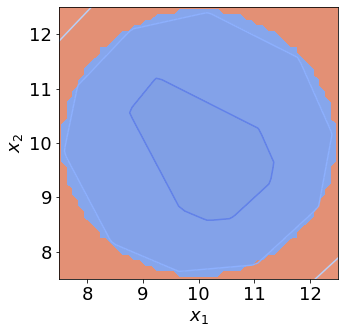

In [24]:
## Plot the contour of the classifier boundary of the rare event set

plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 18

plt.contourf(x1s, x2s, ys,  levels=[-100, 0, 100], cmap="coolwarm")

plt.contourf(x1s, x2s, g_s, cmap="gray", alpha=0.1)
plt.contour(x1s, x2s, g_s,  cmap="coolwarm")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(lb, ub)
plt.ylim(lb, ub)

plt.show()

In [39]:
## Define the GMM model for the q distribution

def gmm_model(mus, ncomps, xs, sigma_diag, weights, dim=2):
    GMM_model = mixture_model.GaussianMixture(n_components=ncomps, covariance_type="diag")
    GMM_model.fit(xs.reshape(-1, dim))
    GMM_model.means_ = mus
    GMM_model.covariances_ = sigma_diag
    GMM_model.weights_ = weights
    return GMM_model
    
def gmm_pdf(xs, GMM_model, dim=2):
    gmm_mus = GMM_model.means_
    ncomps = GMM_model.n_components
    gmm_sigma = GMM_model.covariances_[0]
    gmm_phis = GMM_model.weights_
    

    pdf_values = np.zeros([xs.shape[0], ncomps])
    for i in range(ncomps):
        pdf_values[:, i] = normal.pdf(xs, gmm_mus[i], gmm_sigma*np.eye(2))

    pdf_output = np.dot(pdf_values, gmm_phis)
    return pdf_output

In [29]:
## The objective function and the constraint equation for the optimization problem to find dominating points

def objective(X):
    x = X
    Mu = mu_0
    Sigma = sigma_0
    obj = np.matmul(np.matmul((x-Mu),np.linalg.inv(Sigma)),np.transpose(x-Mu)).item()
    return obj

def eq(X, gamma=-1.1):
    x = X
    g = lambda xx: np.diff(model_net(torch.Tensor(xx).to(device)).cpu().data.numpy(), axis=1)
    return (g(x.reshape(1,2)).item()-gamma)

def eq0(X, gamma=-1.1):
    x = X
    g = lambda xx: np.diff(model_net(torch.Tensor(xx).to(device)).cpu().data.numpy(), axis=1)
    return -(g(x.reshape(1,2)).item()-gamma)

In [40]:
## Define the cutting plane equation as tangent to the NN boundary

def cutting_plane(x, eq, eps=1e-5, rad=1):
    m = approx_fprime(x, eq, eps)
    c =  -np.dot(x, m) 
    hp = lambda xx: (-np.dot(xx, m)-c) - rad
    return hp


def cons_generator(xstar, dim=2):
    Mus = xstar.reshape(-1, dim)
    Sigma = np.eye(dim)
    
    N = Mus.shape[0]
    ineq_const = eq_cons
    
    Mu = Mus[-1,:]
    ineq_i = cutting_plane(Mu, eq)
   
    cons_new = {'type':'ineq', 'fun': ineq_i}            
    ineq_const.append(dict(cons_new))
        
    return ineq_const

def cp(mu, eps=1e-6, rad=2):
    hp = lambda x:  - np.dot(mu.transpose(), (x-mu)) - rad
    return hp

In [41]:
## Iterative cutting plane implementation

# Initialize equality constraint as two inequality constraints
eq_cons = [{'type': 'ineq', 'fun': eq}]

# solve first time with randomized starting point
x0 = mu_0
sol = minimize(objective, x0, method='COBYLA', constraints=eq_cons)
sol

     fun: 18.43842298012063
   maxcv: 3.089904785147368e-05
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([10.98880277, 11.90574784])

Optimization terminated successfully. [11.305749   11.74159232]


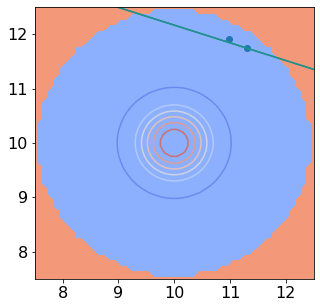

Optimization terminated successfully. [12.03086268 10.87934522]


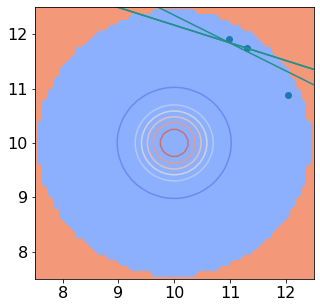

Optimization terminated successfully. [12.24802111  9.59360902]


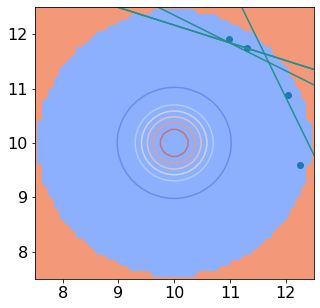

Optimization terminated successfully. [ 9.50103254 12.21347533]


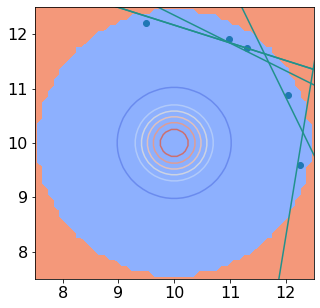

Optimization terminated successfully. [ 9.00918293 12.10217305]


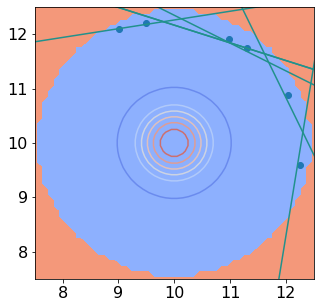

Optimization terminated successfully. [ 8.33634901 11.54249621]


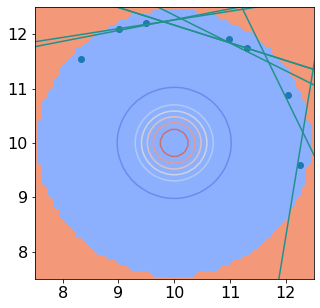

Optimization terminated successfully. [ 7.96925638 11.14652717]


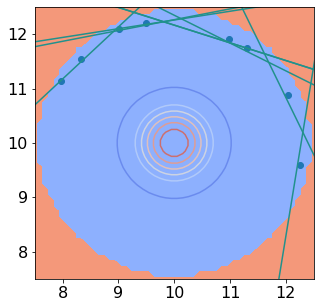

Optimization terminated successfully. [8.07398479 9.01005074]


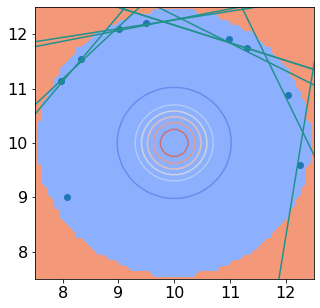

Optimization terminated successfully. [ 7.7486982  10.45500715]


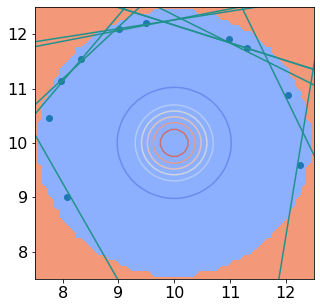

Optimization terminated successfully. [9.09742991 7.9246091 ]


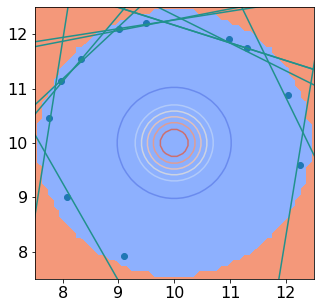

Optimization terminated successfully. [11.57625719  8.33152333]


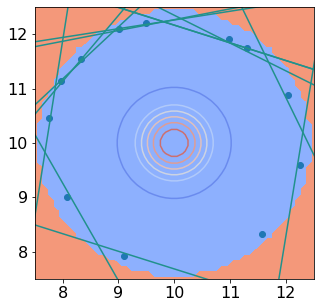

Optimization terminated successfully. [10.20153612  7.72320731]


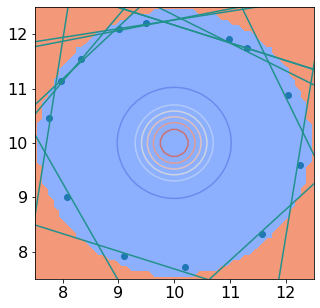

Optimization terminated successfully. [10.94195589  7.78909558]


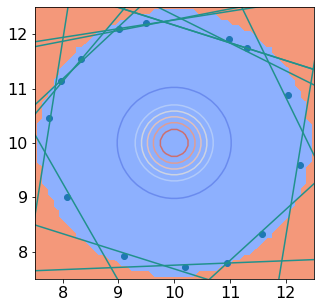

Optimization terminated successfully. [8.64842524 8.11993328]


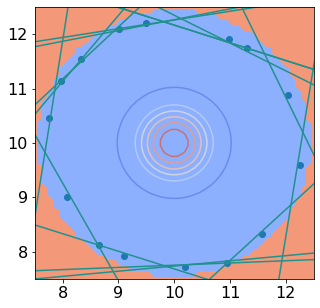

All iterations done! Dom points: 
[[10.98880277 11.90574784]
 [11.305749   11.74159232]
 [12.03086268 10.87934522]
 [12.24802111  9.59360902]
 [ 9.50103254 12.21347533]
 [ 9.00918293 12.10217305]
 [ 8.33634901 11.54249621]
 [ 7.96925638 11.14652717]
 [ 8.07398479  9.01005074]
 [ 7.7486982  10.45500715]
 [ 9.09742991  7.9246091 ]
 [11.57625719  8.33152333]
 [10.20153612  7.72320731]
 [10.94195589  7.78909558]
 [ 8.64842524  8.11993328]]


In [32]:
## The iterative cutting plane algorithm using scipy optimization

if sol.status ==1:
    x0 = sol.x
    xstar = sol.x.reshape(-1, 2)
    cons = cons_generator(xstar)
    
num_iters = 500
np.random.seed(0)
x0_trials = p.rvs(num_iters)

#iterate
h1 = cutting_plane(sol.x, eq)
hs_all = np.array(h1)
for it in range(num_iters):
    
    # re-solve
    sol = minimize(objective, x0, method='COBYLA', constraints=cons)
        
    # check status
    if (sol.status ==1)*(eq(sol.x)<0) :
        xstar = np.append(xstar, sol.x).reshape(-1, 2)
        
        #generate constraints
        cons = cons_generator(xstar)
        #print(cons)
        
        #restart to mu
        x0 = sol.x
        print(sol.message, sol.x)
        
        h1 = cutting_plane(xstar[-2, :], eq)
        hs_all = np.append(hs_all, h1)
        h1s = h1(xs).reshape(x1s.shape)
        
        plt.figure(figsize=(5, 5))
        plt.rcParams["font.size"] = 16

        for it in range(hs_all.shape[0]):    
            hcurrent = hs_all[it]    
            h1s = hcurrent(xs).reshape(x1s.shape)                    
            plt.contour(x1s, x2s, h1s, cmap="viridis", levels=[-1000, 0, 1000])
            
        plt.contourf(x1s, x2s, ys,  levels=[-100, 0, 100], cmap="coolwarm")
        plt.contour(x1s, x2s, ps, cmap="coolwarm", alpha=0.8)
        #plt.contour(x1s, x2s, g_s, cmap="gray", levels=[-1000, gamma, 1000])
        plt.scatter(xstar[:, 0], xstar[:,1])
        plt.xlim(lb, ub)
        plt.ylim(lb, ub)        
        plt.show()
        
        
    else:
        x0 = x0_trials[it,:]
        
print('All iterations done! Dom points: ')
print(xstar)

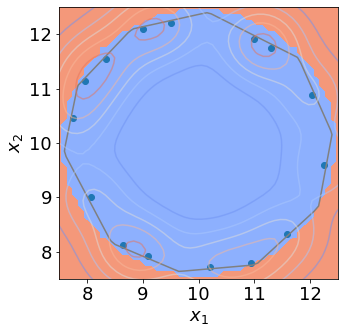

In [42]:
## Calculate 'q' as a GMM with components centered around the dominating points

n_mixtures = np.array(xstar).shape[0]
sigmas = sigma_0[0, 0]*np.ones([n_mixtures, 1])
weights = np.ones([n_mixtures, 1])/n_mixtures

gmm_A = gmm_model(xstar, n_mixtures, xs, sigmas, weights)
gmm_a_s = gmm_pdf(xs, gmm_A).reshape(x1s.shape)


q = gmm_A
qs = gmm_pdf(xs, q).reshape(x1s.shape)
gamma = 0

plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 18
#plt.contourf(x1s, x2s, h_s, cmap="coolwarm", levels=50)
plt.contourf(x1s, x2s, ys,  levels=[-100, 0, 100], cmap="coolwarm")
plt.contour(x1s, x2s, g_s, cmap="gray", levels=[-100, gamma, 100])
plt.contour(x1s, x2s, gmm_a_s, cmap="coolwarm", alpha=0.5)
plt.scatter(xstar[:, 0], xstar[:, 1])

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(lb, ub)
plt.ylim(lb, ub)

plt.show()

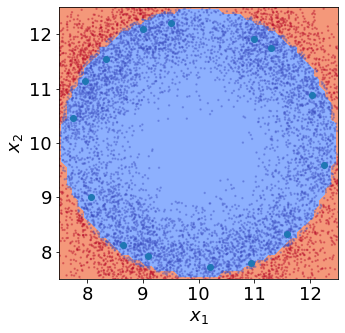

In [43]:
## Plot the sampled points from the Importance Sampling distribution 'q'

N=10000
X=q.sample(N)[0]
Y = f(X, mu_non_eps, thres)

plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 18
plt.contourf(x1s, x2s, ys, levels=[-1, 0, 1], cmap="coolwarm")

#plt.contourf(x1s, x2s, h_s, levels=[-100, gamma, 100],  cmap="gray", alpha=0.1)
#plt.contour(x1s, x2s, g_s, levels=[-100, gamma, 100],  cmap="coolwarm")

#plt.contour(x1s, x2s, gmm_a_s, cmap="coolwarm", alpha=0.5)
plt.scatter(X[:,0], X[:,1], s=2, c=Y, alpha=0.3, cmap="coolwarm", label="Sample from p")
#plt.scatter(mu_0[0], mu_0[1], c="k", label="$\mu_0$")

plt.scatter(xstar[:, 0], xstar[:, 1], c='C0', zorder=10)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(lb, ub)
plt.ylim(lb, ub)

plt.show()

In [44]:
## Compare the D-PrAE method with Monte Carlo in terms of variance, relative error estimated mean

K=10
d = 2

ns = np.arange(50000, 525000, 25000)

mus_mc = np.zeros(ns.shape)
var_mus_mc = np.zeros(ns.shape)

mus_is = np.zeros(ns.shape)
var_mus_is = np.zeros(ns.shape)

mus_is_ub = np.zeros(ns.shape)
var_mus_is_ub = np.zeros(ns.shape)

mus_is_lb = np.zeros(ns.shape)
var_mus_is_lb = np.zeros(ns.shape)


i=0
for n in ns:
    mu_mc = np.zeros(K)
    mu_is = np.zeros(K)
    mu_is_ub = np.zeros(K)
    mu_is_lb = np.zeros(K)
    
    for k in range(K):
        #MC
        X_p = p.rvs(n)
        Y_p = f(X_p, mu_non_eps, thres)
        mu_mc[k] = Y_p.mean(axis=0)
        
        #IS sampler
        X_q = q.sample(n)[0]
        W = np.divide(p.pdf(X_q), gmm_pdf(X_q, q).reshape(-1,))
        
        #IS estimator
        Y_q = f(X_q, mu_non_eps, thres)
        mu_is[k] = np.multiply(Y_q, W).mean(axis=0)  

        
        #D-PrAE UB
        gamma = 0
        Y_q = (g(X_q) > gamma).reshape(-1, )
        mu_is_ub[k] = np.multiply(Y_q, W).mean(axis=0)  
        
        #D-PrAE LB
        gamma = 5
        Y_q = (g(X_q) > gamma).reshape(-1, )
        mu_is_lb[k] = np.multiply(Y_q, W).mean(axis=0)  
        
        
        print("It {}, Rep {}".format(i, k), end="\r")
        
    
    mus_mc[i]=mu_mc.mean()
    var_mus_mc[i]=mu_mc.var()
    
    mus_is[i]=mu_is.mean()
    var_mus_is[i]=mu_is.var()
    
    mus_is_ub[i]=mu_is_ub.mean()
    var_mus_is_ub[i]=mu_is_ub.var()

    mus_is_lb[i]=mu_is_lb.mean()
    var_mus_is_lb[i]=mu_is_lb.var()

    i=i+1
        

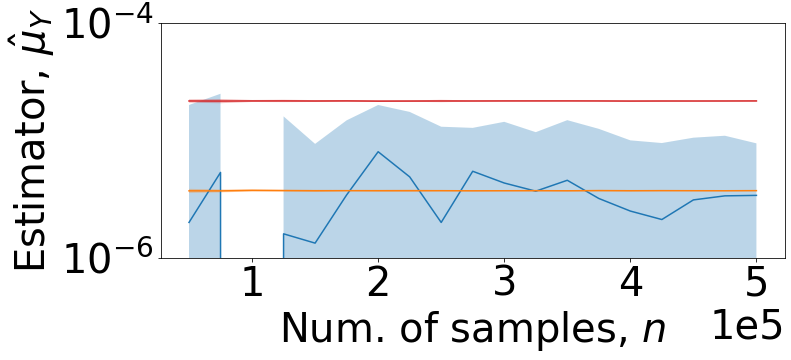

In [47]:
plt.figure(figsize=[12, 6])
plt.rcParams["font.size"] = 40

hw_mus_mc = np.sqrt(var_mus_mc)
hw_mus_is = np.sqrt(var_mus_is)
hw_mus_is_ub = np.sqrt(var_mus_is_ub)
hw_mus_is_lb = np.sqrt(var_mus_is_lb)

plt.plot(ns, mus_mc, label="MC")
plt.fill_between(ns, mus_mc-3*hw_mus_mc, mus_mc+3*hw_mus_mc, alpha=0.3, facecolor="C0")

plt.plot(ns, mus_is, label="D-PrAE IS", c="C1")
plt.fill_between(ns, mus_is-3*hw_mus_is, mus_is+3*hw_mus_is, alpha=0.3, facecolor="C1")

plt.plot(ns, mus_is_ub, label="D-PrAE UB", c="C3")
plt.fill_between(ns, mus_is_ub-3*hw_mus_is_ub, mus_is_ub+3*hw_mus_is_ub, alpha=0.3, facecolor="C3")

plt.xlabel("Num. of samples, $n$")
plt.ylabel("Estimator, $\hat \mu_Y$")
plt.ylim([1e-6, 1e-4])
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()

plt.show()

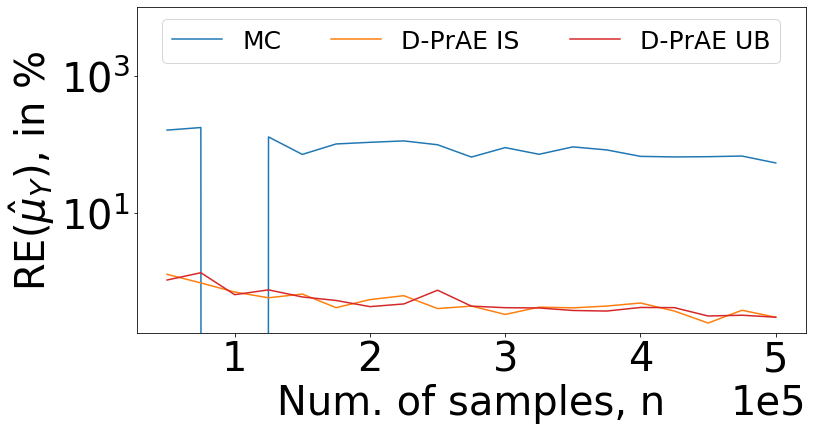

In [48]:
plt.figure(figsize=[12, 6])
plt.rcParams["font.size"] = 40

re_mus_mc = np.divide(hw_mus_mc, mus_is)
re_mus_is = np.divide(hw_mus_is, mus_is)
re_mus_is_lb = np.divide(hw_mus_is_lb, mus_is_lb)
re_mus_is_ub = np.divide(hw_mus_is_ub, mus_is_ub)

plt.plot(ns, re_mus_mc*100, c="C0", label="MC")
plt.plot(ns, re_mus_is*100, c="C1", label="D-PrAE IS")
#plt.plot(ns, re_mus_is_lb*100, c="C2", label="D-PrAE LB")
plt.plot(ns, re_mus_is_ub*100, c="C3", label="D-PrAE UB")

plt.xlabel("Num. of samples, n")
plt.ylabel("RE($\hat \mu_Y$), in %")

plt.yscale("log")
plt.ylim([None, 1e4])

plt.legend(loc=9, ncol=3)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(loc=9, ncol=3, fontsize=25)

plt.show()